## MRR@100 на данных Yandex Cup 2022 RecSys


In [2]:
import timeit

import pandas as pd
import numba as nb
import numpy as np
from rectools import Columns
import requests
from tqdm.auto import tqdm


from matplotlib import pyplot as plt

In [3]:
np.random.seed(33)

! mkdir data

mkdir: cannot create directory ‘data’: File exists


In [4]:
!wget https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip -O data/data_orig.zip

--2023-03-04 10:23:56--  https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78795385 (75M) [application/zip]
Saving to: ‘data/data_orig.zip’

data/data_orig.zip  100%[===================>]  75.14M  2.36MB/s    in 40s     

2023-03-04 10:24:39 (1.88 MB/s) - ‘data/data_orig.zip’ saved [78795385/78795385]



In [7]:
!unzip data/data_orig.zip -d data 


Archive:  data/data_orig.zip
replace data/kion_train/interactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [17]:
interactions = pd.read_csv('data/kion_train/interactions.csv')

users = pd.read_csv('data/kion_train/users.csv')
items = pd.read_csv('data/kion_train/items.csv')

In [18]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [19]:
interactions.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        int64  
 1   item_id        int64  
 2   last_watch_dt  object 
 3   total_dur      int64  
 4   watched_pct    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 517.0 MB


## Проверка


In [20]:
def generate_subsample(users_count, top_k, data=interactions):
    users = np.random.choice(data['user_id'].unique(), users_count, replace=False)
    df = data[data['user_id'].isin(users)].reset_index(drop=True)
    del df['last_watch_dt'], df['total_dur'], df['watched_pct']
    recs = np.random.choice(df['item_id'], size=(users_count, top_k))
    return df, users, recs

### Считаем метрики

In [31]:
def naive_mrr(target, users, recs):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(users)

@nb.njit(cache=True, parallel=True)
def numba_mrr(target, users, recs):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user_mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

def pandas_mrr(df, sample_users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({
        'user_id': np.repeat(sample_users,k),
        'item_id': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df_merge = df_recs.merge(df, how='inner', on=['user_id','item_id'])
    df_merge['pos_rank'] = df_merge.groupby('user_id').cumcount() + 1
    df_merge = df_merge[df_merge['pos_rank'] == 1]
    df_merge['item_val'] = 1 / df_merge['rank']
    return df_merge['item_val'].sum() / len(sample_users)

In [32]:
users_counts = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

In [34]:
avg_time_naive = np.zeros((len(users_counts), 5))
avg_time_numba = np.zeros((len(users_counts), 5))
avg_time_pandas = np.zeros((len(users_counts), 5))

In [37]:
for i, count in enumerate(users_counts):
    for j, k in enumerate(top_k):
        df, users, recs = generate_subsample(count, k)
        target = df.values
        n_runs = 4

        print(f'Run naive user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('naive_mrr(target, users, recs)', "from __main__ import naive_mrr, target, users, recs" , number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_naive[i][j] = t / n_runs
              
        print(f'Run numba user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('numba_mrr(target, users, recs)', "from __main__ import numba_mrr, target, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_numba[i][j] = t / n_runs
               
        print(f'Run pandas user_count: {count}, top_k: {k} for {n_runs} times')
        t = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, users, recs", number=n_runs)
        print(f'Avg time: {t / n_runs:0.4f} seconds')
        avg_time_pandas[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 4 times
Avg time: 0.0062 seconds
Run numba user_count: 100, top_k: 10 for 4 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 10 for 4 times
Avg time: 0.0110 seconds
Run naive user_count: 100, top_k: 50 for 4 times
Avg time: 0.0182 seconds
Run numba user_count: 100, top_k: 50 for 4 times
Avg time: 0.0003 seconds
Run pandas user_count: 100, top_k: 50 for 4 times
Avg time: 0.0124 seconds
Run naive user_count: 100, top_k: 100 for 4 times
Avg time: 0.0252 seconds
Run numba user_count: 100, top_k: 100 for 4 times
Avg time: 0.0002 seconds
Run pandas user_count: 100, top_k: 100 for 4 times
Avg time: 0.0109 seconds
Run naive user_count: 1000, top_k: 10 for 4 times
Avg time: 0.0850 seconds
Run numba user_count: 1000, top_k: 10 for 4 times
Avg time: 0.0085 seconds
Run pandas user_count: 1000, top_k: 10 for 4 times
Avg time: 0.0136 seconds
Run naive user_count: 1000, top_k: 50 for 4 times
Avg time: 0.1875 seconds
Run numba user_count: 1000,

### Строим графики

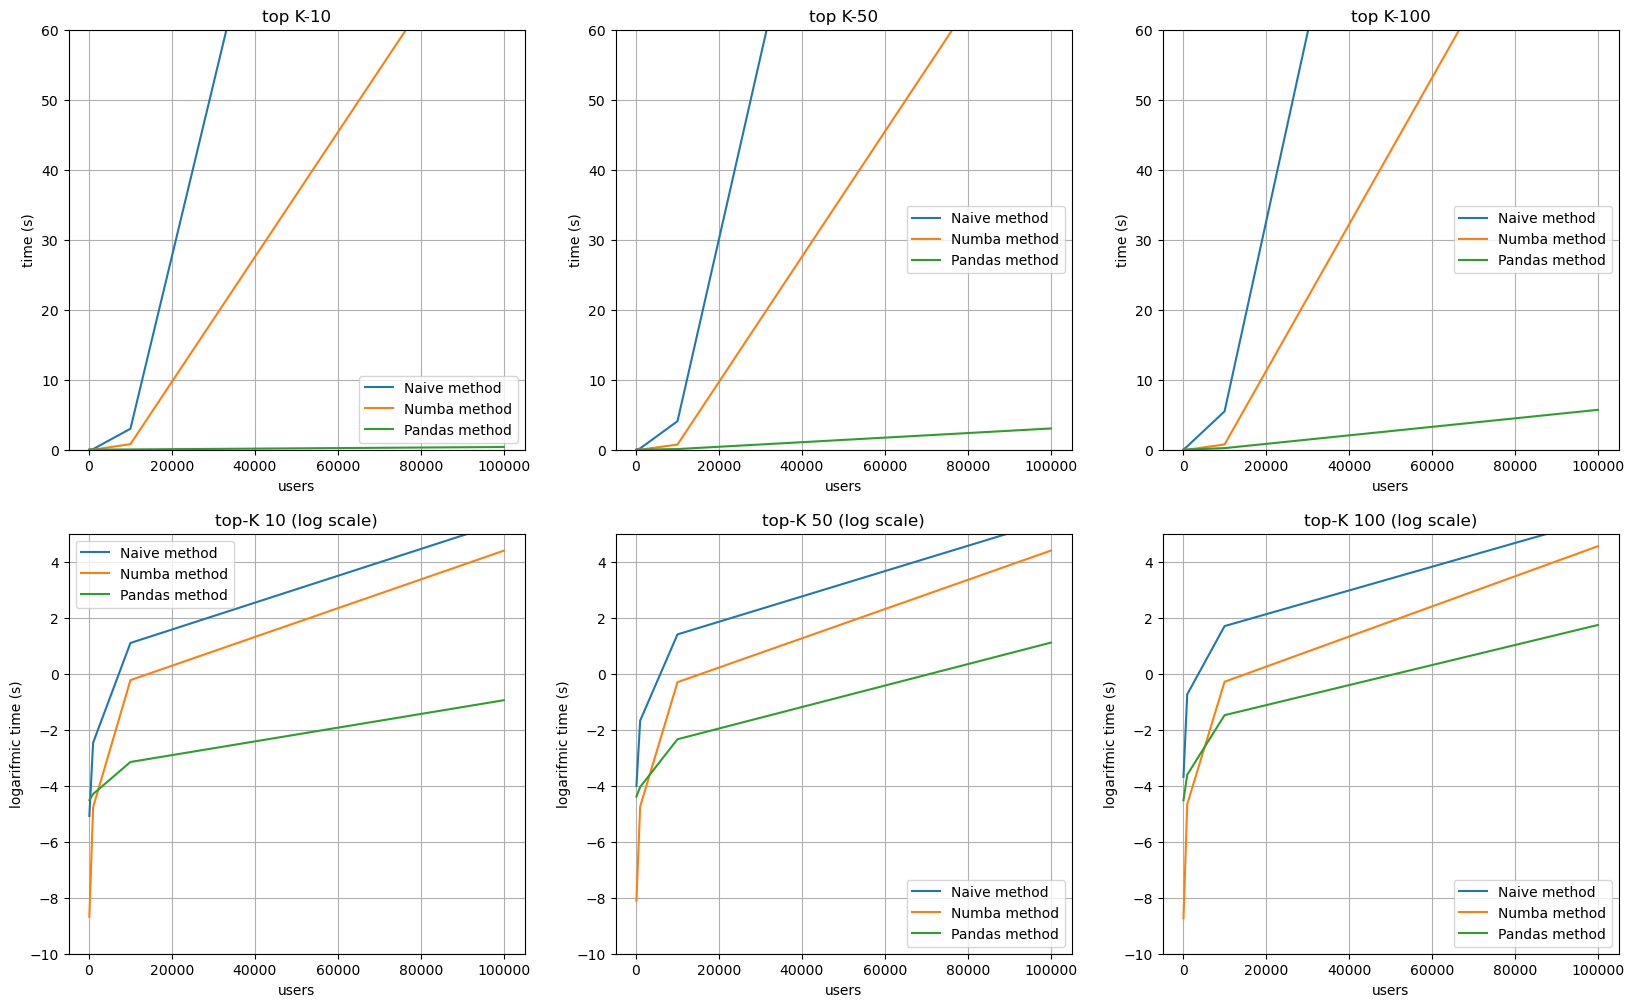

In [41]:
_, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(3):
    ax[0][i].plot(users_counts, avg_time_naive[:, i], label='Naive method')
    ax[0][i].plot(users_counts, avg_time_numba[:, i], label='Numba method')
    ax[0][i].plot(users_counts, avg_time_pandas[:, i], label='Pandas method')
    ax[0][i].set_title(f'top K-{top_k[i]}')
    ax[0][i].set_xlabel('users')
    ax[0][i].set_ylabel('time (s)')
    ax[0][i].set_ylim(0, 60)
    ax[0][i].grid()
    ax[0][i].legend()
    
    # в логарифмической шкале
    ax[1][i].plot(users_counts, np.log(avg_time_naive[:, i]), label='Naive method')
    ax[1][i].plot(users_counts, np.log(avg_time_numba[:, i]), label='Numba method')
    ax[1][i].plot(users_counts, np.log(avg_time_pandas[:, i]), label='Pandas method')
    ax[1][i].set_title(f'top-K {top_k[i]} (log scale)')
    ax[1][i].set_xlabel('users')
    ax[1][i].set_ylabel('logarifmic time (s)')
    ax[1][i].set_ylim(-10, 5)
    ax[1][i].grid()
    ax[1][i].legend()
plt.show()